# Initial Test Data Analysis
See [This GitLAB Issue](https://code.crearecomputing.com/hearingproducts/open-hearing-group/open-hearing-hardware/-/issues/1) for details ont he data collection. 

In this notebook:

0. Load Common Data Structure (Setup)
1. Fine-tune calibration of mic positions
2. Mic amplitude calibrations
3. Mic phase calibrations

## 0. Load Common Data Structures

In [1]:
%matplotlib inline

In [2]:
# Import dependencies
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, ndimage
from pint import UnitRegistry
units = UnitRegistry()

from owai.core import io
from owai.core import signal_processing_utils as spu

In [3]:
# Figure style and line style
figkwargs = dict(figsize=(6.5, 6.5 / 1.618034), dpi=200)
linekwargs = dict(lw=1, alpha=0.5)

# Set up path to the data
path = os.path.join("Olympus", "Projects", "1010564-OPEN-HEARING", "Technical Work", "Testing", "Data", "2024-02-23_OWAI-Calibration-Data-Collection")  # From windows
if os.environ.get("OLYMPUS_PROJECTS_PATH", False):
    path = path.replace(os.path.join('Olympus', "Projects"), os.environ.get("OLYMPUS_PROJECTS_PATH"))
print("Looking for data in this path:", path)

path_meta = os.path.join(path, 'testdata.yaml')
print("Looking for test meta data in this path:", path_meta)

# Load test metadata
test_meta = io.load_test_data(path_meta)
# pprint(test_meta)

# Set constants
speed_of_sound = 343 * units.m / units.s
n_channels = 4

Looking for data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-02-23_OWAI-Calibration-Data-Collection
Looking for test meta data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-02-23_OWAI-Calibration-Data-Collection/testdata.yaml


# Fine-Tune Mic Positions

Idea is to see how an impulse travels across the array and see if timing matches up with the expected geometry.

In [4]:
lengths_nominal = test_meta["probe_geometry"]['mic_positions']['value'] * units(test_meta["probe_geometry"]['mic_positions']['units'])
lengths_nominal

Magnitude,[0.4 5.9 9.5 13.4]
Units,millimeter


In [5]:
# Load all availabl data, and concatenate
times = []
data = []
last_t = 0
for tests in test_meta["test_metadata"]["impulse"]["files"]:
    fn = os.path.join(path, tests[0])
    t, d, samplerate = io.load_wav(fn)
    times.append(t + last_t)
    last_t = t[-1] + last_t + t[1]
    data.append(d)
times = np.concatenate(times)
data = np.concatenate(data)

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000


In [6]:
# plt.close(1)
# plt.figure(1, **figkwargs)
# plt.plot(times, data, **linekwargs)
# plt.xlabel("time (s)")
# plt.ylabel("amplitude (uncal)")
# plt.title("Impulse data")
# plt.legend(range(4))
# plt.show()

In [7]:
# Let's find all the max events in the file

# First, subtract out the mean up to the current point. This lets us find jumps in the data with a threshold
kernel_size = 65
kernel_lag_mean = np.ones(kernel_size)
kernel_lag_mean[:kernel_size // 2 + 1] = 0  # Reversed because convolutions flip the kernel... so we average the data to the left
kernel_lag_mean /= kernel_lag_mean.sum()
data_lag_mean = ndimage.convolve1d(data, kernel_lag_mean, axis=0)
data_minus_mean = data - data_lag_mean

# Now find the maxima in the data with the means removed
data_max = ndimage.maximum_filter1d(np.abs(data_minus_mean), kernel_size, axis=0)

# Figure out an appropriate threshold to identify "events"
# channel_noise_max = data_minus_mean[:samplerate].max(axis=0)
channel_noise_std = data_minus_mean[:samplerate].std(axis=0)
channel_noise_thresh = (channel_noise_std).max() * 100

# Now find the location of the events
inds_event = np.all(data_max > channel_noise_thresh, axis=1)
data_event = data_minus_mean[inds_event]
time_event = times[inds_event]

# find indices where events start... the starts of blocks of True
ints_event = np.argwhere((inds_event[1:] == True) & (inds_event[:-1] == False))[:, 0] + 1

# Events should be separated by at least 0.25 seconds
EVENT_SEPARATION_SECONDS = 0.25
ints_event = np.concatenate([ints_event[:1], ints_event[ints_event > np.roll(ints_event, 1) + samplerate * EVENT_SEPARATION_SECONDS]])

Text(0, 0.5, 'Amplitude (uncal)')

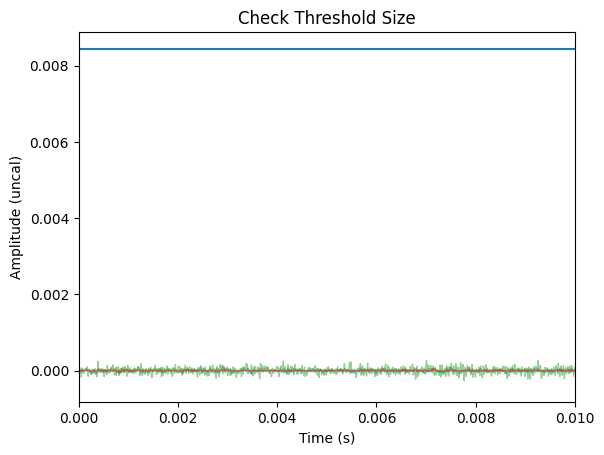

In [8]:
# Debug Plot
plt.close(101)
plt.figure(101)
n = samplerate
plt.plot(times[:n], data_minus_mean[:n, :], **linekwargs)
plt.gca().set_prop_cycle(None)
plt.plot([times[0], times[n]], [channel_noise_thresh]*2)
plt.xlim(0, 0.01)
plt.title("Check Threshold Size")
plt.xlabel('Time (s)')
plt.ylabel("Amplitude (uncal)")

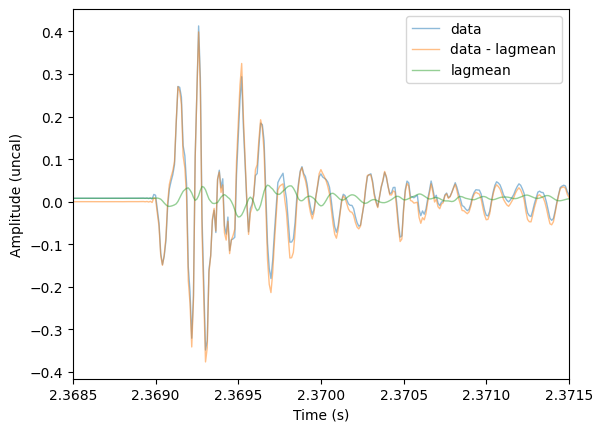

In [9]:
# Debug Plot
plt.close(102)
plt.figure(102)
n = samplerate*4
plt.plot(times[:n], data[:n, 0], **linekwargs)
plt.plot(times[:n], data_minus_mean[:n, 0], **linekwargs)
plt.plot(times[:n], data_lag_mean[:n, 0], **linekwargs)
plt.gca().set_prop_cycle(None)
# plt.plot([times[0], times[n]], [channel_noise_thresh]*2)
plt.legend(["data", "data - lagmean", "lagmean"])
plt.xlim(2.3685, 2.3715)
plt.xlabel('Time (s)')
plt.ylabel("Amplitude (uncal)");

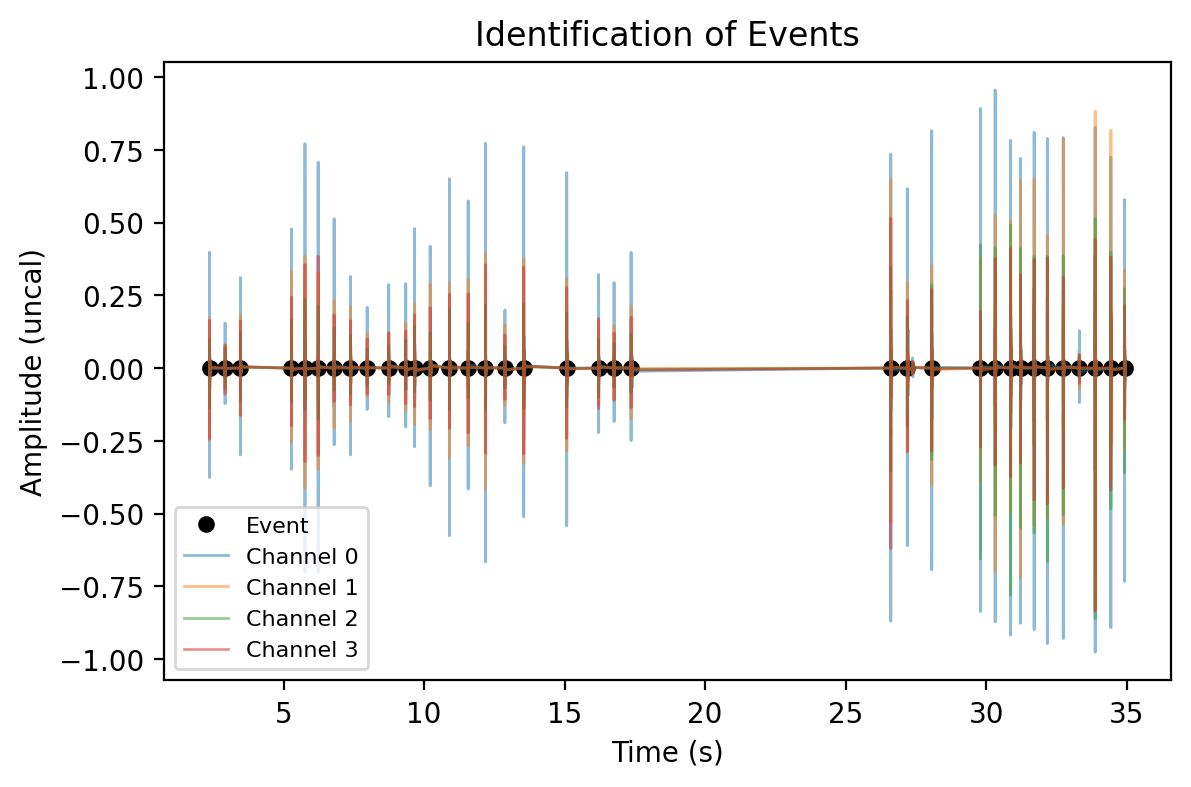

In [10]:
plt.close(2)
plt.figure(2, **figkwargs)
plt.plot(times[ints_event], ints_event * 0, 'ok', ms=5)
plt.plot(time_event, data_event, **linekwargs)
# plt.plot(times, data_minus_mean, **linekwargs)
plt.title("Identification of Events")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uncal)")
plt.legend(["Event", "Channel 0", "Channel 1", "Channel 2", "Channel 3"], fontsize=8, loc=3)
plt.show();

In [11]:
# Only look at the data up to the first extremum
data_max3 = ndimage.maximum_filter1d(np.abs(data_minus_mean), 3, axis=0)
data_max3_inds = (data_max3 == np.abs(data_minus_mean)) & (data_max3 > channel_noise_thresh)
data_max3_nans = np.ones(data_max3_inds.shape) # For plotting
data_max3_nans[~data_max3_inds] = np.nan

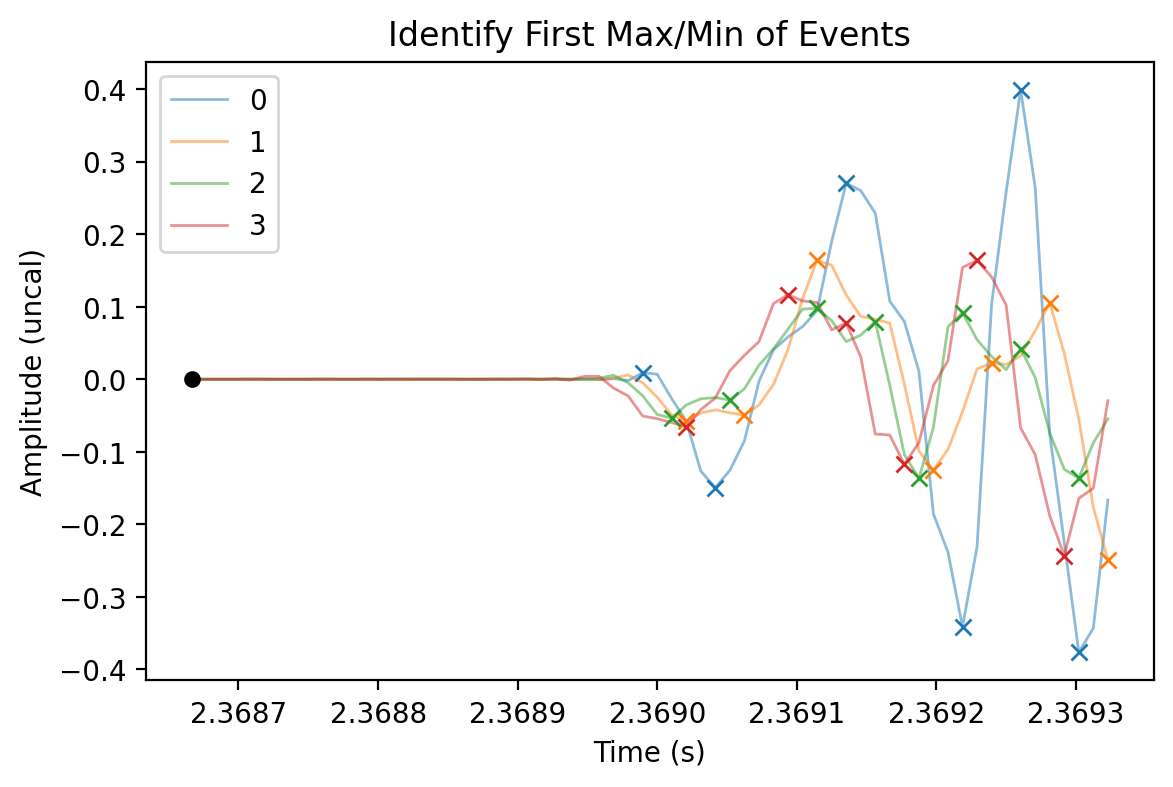

In [12]:
# Plot the first event
event_ind = 0
slc = slice(ints_event[event_ind], ints_event[event_ind] + 64)
plt.close(3)
plt.figure(3, **figkwargs)
plt.plot(times[slc], data_minus_mean[slc], **linekwargs)
plt.gca().set_prop_cycle(None)
plt.plot(times[slc], data_max3_nans[slc] * data_minus_mean[slc], 'x')
plt.plot(times[slc.start], 0, 'ok', ms=5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uncal)")
plt.title("Identify First Max/Min of Events")
plt.legend(range(4))
plt.show()

In [13]:
# find the indices for all of these "first max after event" for all channels and all events
ints_local_maxes = [np.argwhere(data_max3_inds[:, c])[:, 0] for c in range(n_channels)]

# Subselect the data for all these event, and add a buffer around the signal for sub-sample alignment
data_buffer = 6  # At least 1

data_segment_lenghts = 16
event_data_segments = np.zeros((ints_event.size, data.shape[1], data_segment_lenghts + 2 * data_buffer))
event_data_times = np.zeros((ints_event.size, data.shape[1], data_segment_lenghts + 2 * data_buffer))
event_start_stop_inds = []
for i, int_event in enumerate(ints_event):
    for c in range(n_channels):
        stop = ints_local_maxes[c][np.argwhere(ints_local_maxes[c] > int_event)[0, 0]] + 1
        if stop < (int_event + data_segment_lenghts):
            # Something went wrong, don't include this event
            continue
        slc = slice(stop - data_segment_lenghts - data_buffer, stop + data_buffer)
        event_data_segments[i, c, :] = data_minus_mean[slc, c]
        event_data_times[i, c, :] = times[slc]

# Eliminate unpopulated events
keep = ~np.all(event_data_segments[:, 0] == 0, axis=-1)
event_data_segments = event_data_segments[keep, :, :]
event_data_times = event_data_times[keep, :, :]

# normalize
event_data_times_norm = event_data_times - event_data_times[:, :, :1]
event_data_times_ref = event_data_times - event_data_times[:, -1:, :1]
event_data_segments_norm = event_data_segments / event_data_segments[:, :, -data_buffer-1:-data_buffer]

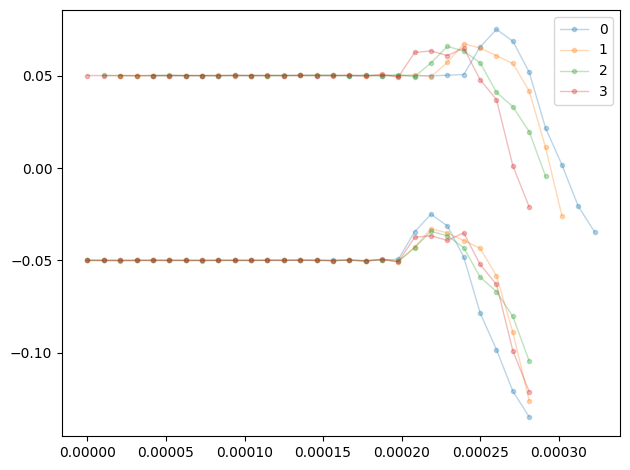

In [14]:
# debug plot
e = 7
plt.close(103)
plt.figure(103)
shift = event_data_segments[e, :].max()
for i in range(n_channels):
    # plt.plot(event_data_times[e, i], event_data_segments_norm[e, i], ".-C" + str(i), lw=1, alpha=0.3)
    plt.plot(event_data_times_ref[e, i], event_data_segments[e, i] * [0.5, 1, 1,1][i] + shift, ".-C" + str(i), lw=1, alpha=0.3)
for i in range(n_channels):
    plt.plot(event_data_times_norm[e, i], event_data_segments[e, i] * [0.5, 1, 1,1][i] - shift, ".-C" + str(i), lw=1, alpha=0.3)
plt.legend(range(n_channels))
plt.tight_layout()
plt.show()

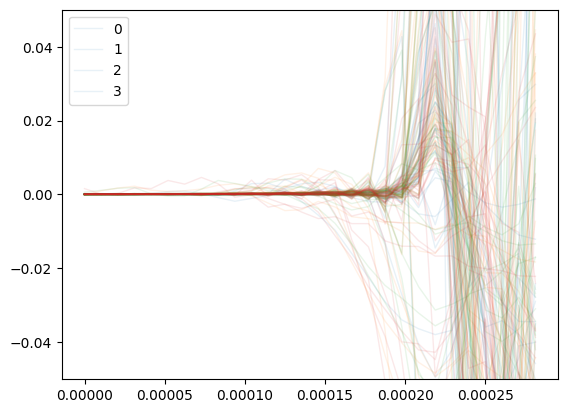

In [15]:
# debug plot
e = 7
plt.close(104)
plt.figure(104)
# for i in range(n_channels):
#     plt.plot(event_data_times_norm[e, i], event_data_segments[e, i], ".-C" + str(i), lw=1, alpha=0.3)
# for i in range(n_channels):
#     plt.plot(event_data_times_ref[0, i], event_data_segments[0, i], ":C" + str(i), lw=1, alpha=0.3)
for i in range(n_channels):
    plt.plot(event_data_times_norm[:, i].T, event_data_segments[:, i].T * [0.5, 1, 1,1][i], "C" + str(i), lw=1, alpha=0.1)
plt.legend(range(n_channels))
plt.ylim([-shift, shift])
plt.show()

In [16]:
# Compute the sub-sample offsets of all these events
ref_channel=-1
offsets, costs, old_costs = spu.find_subsample_alignment_offsets(
    event_data_times_ref, event_data_segments, buffer=data_buffer, ref_channel=ref_channel, cost_type="corr")
event_data_times_norm_off = event_data_times_norm + offsets[..., None]

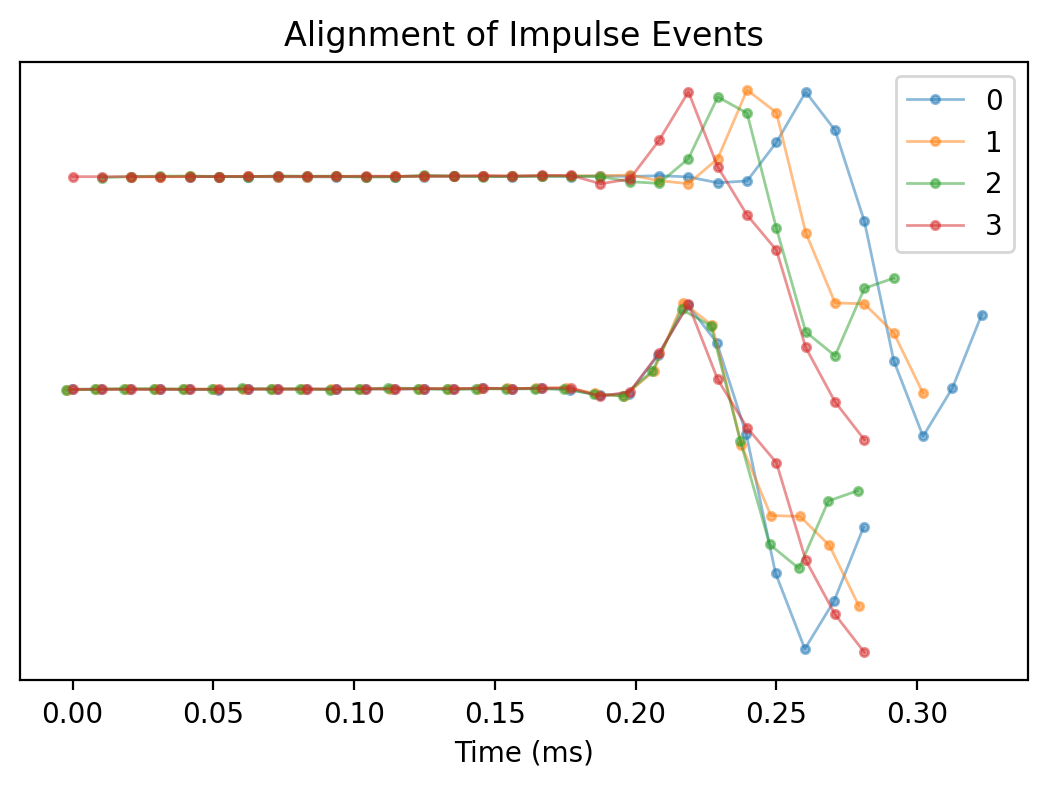

In [17]:
e = 1
shift = event_data_segments[e, :].max() / 2
plt.close(4)
plt.figure(4, **figkwargs)
for i in range(n_channels):
    # Multiply first channel by half because it contains the reflection (i.e. double the pressure)
    plt.plot((event_data_times_ref[e, i] + offsets[e, i]) * 1000,-shift + event_data_segments[e, i] * [0.4, 1, 1, 1][i], ".-C" + str(i), **linekwargs)
for i in range(n_channels):
    plt.plot(event_data_times_ref[e, i] * 1000, shift + event_data_segments[e, i] * [0.4, 1, 1, 1][i], ".-C" + str(i), **linekwargs)
plt.legend(range(n_channels))
plt.xlabel("Time (ms)")
plt.yticks([])           
plt.title("Alignment of Impulse Events")
plt.show()

In [18]:
# Now we have everything we need to compute distance the offsets
# rough_offset = (((event_data_times[:, :, 0] - event_data_times[:, ref_channel, 0][:, None]) * units.s) * speed_of_sound).to('mm')
fine_offsets = ((offsets * units.s) * speed_of_sound).to('mm')
expected_offsets = lengths_nominal[:] - lengths_nominal[-1]

iter = 6
offset_mask = np.abs(fine_offsets - expected_offsets) < (1 * units.mm)
# Remove outliers iteratively
for i in range(iter):
    fine_offset = (fine_offsets * offset_mask).sum(axis=0) / offset_mask.sum(axis=0)
    offset_std = np.sqrt((offset_mask * (fine_offsets - fine_offset) ** 2).sum(axis=0) / offset_mask.sum(axis=0))
    offset_mask = np.abs(fine_offsets - fine_offset) < offset_std * 3
    offset_mask[:, ref_channel] = True
    print(fine_offset)
# shift coordinates to align with nominal lengths
fine_offsets = fine_offsets - fine_offset[-1] + lengths_nominal[-1]
fine_offset = fine_offset - fine_offset[-1] + lengths_nominal[-1]
fine_offset

[-13.466963949377517 -7.629245734668778 -3.8559167510469807 0.0] millimeter
[-13.880282209970167 -7.6553326356496365 -3.82281765037401 0.0] millimeter
[-13.880282209970167 -7.65545989565344 -3.7777903626890663 0.0] millimeter
[-13.880282209970167 -7.603873047093513 -3.7777903626890663 0.0] millimeter
[-13.880282209970167 -7.603873047093513 -3.7777903626890663 0.0] millimeter
[-13.880282209970167 -7.603873047093513 -3.7777903626890663 0.0] millimeter


Magnitude,[-0.48028220997016646 5.796126952906487 9.622209637310934 13.4]
Units,millimeter


/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Text(0.5, 1.0, 'Mic Positions')

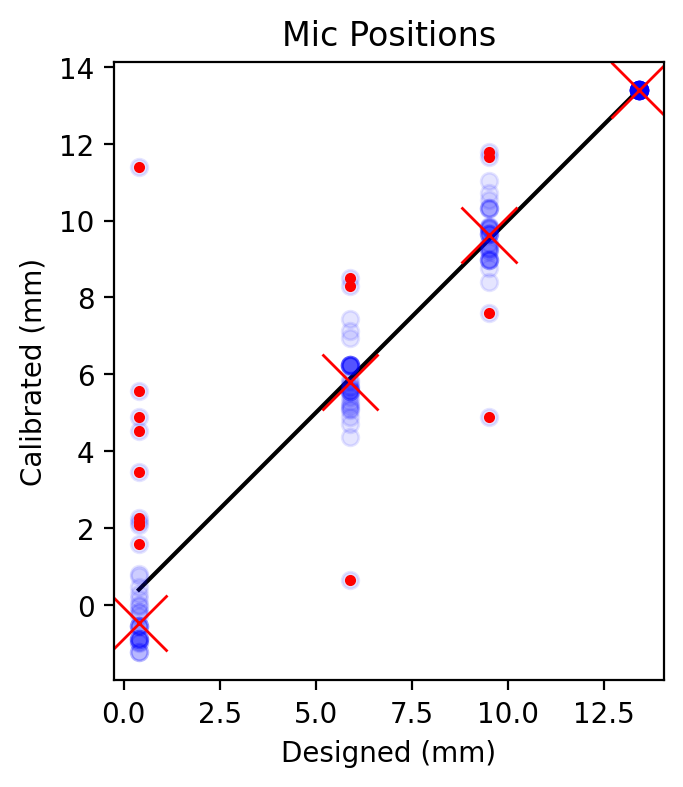

In [19]:
plt.close(8)
plt.figure(8, **figkwargs)
offset_nan = np.ones(offset_mask.shape)
offset_nan[offset_mask] = np.nan
plt.plot(lengths_nominal, lengths_nominal, 'k')
plt.plot(lengths_nominal, fine_offsets.T, 'bo', alpha=0.1)
plt.plot(lengths_nominal, fine_offsets.T * offset_nan.T, 'r.', alpha=1)
plt.plot(lengths_nominal, fine_offset, 'rx', ms=20)
plt.axis('scaled')
# plt.xlim([0, None])
# plt.ylim([0, None])
plt.xlabel("Designed (mm)")
plt.ylabel("Calibrated (mm)")
plt.title("Mic Positions")

Text(0.5, 1.0, 'Mic Positions ')

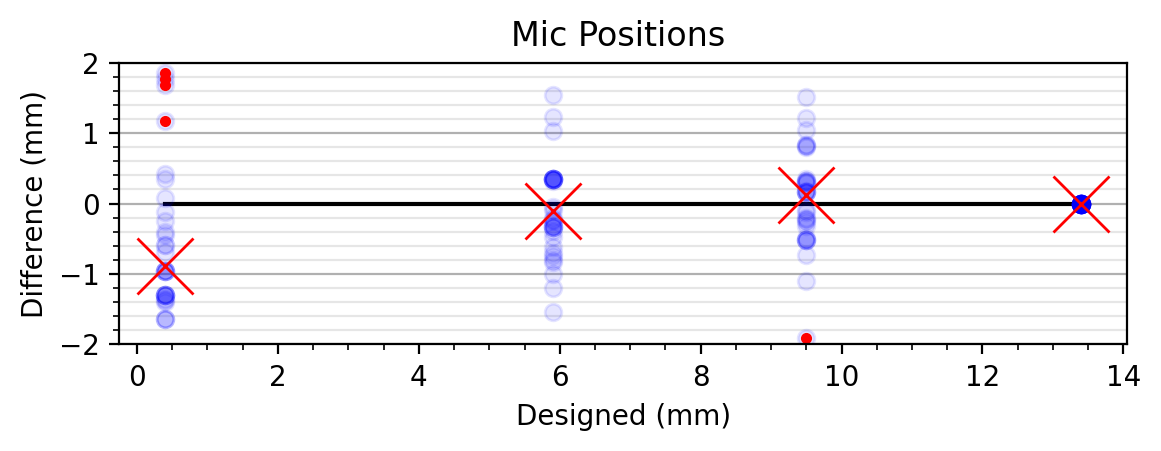

In [20]:
offset_nan = np.ones(offset_mask. shape)
offset_nan[offset_mask] = np.nan
plt.figure(**figkwargs)
plt.plot(lengths_nominal, lengths_nominal * 0, 'k')
plt.plot(lengths_nominal, fine_offsets.T - lengths_nominal[:, None], 'bo', alpha=0.1)
plt.plot(lengths_nominal, (fine_offsets.T - lengths_nominal[:, None]) * offset_nan.T, 'r.', alpha=1)
plt.plot(lengths_nominal, fine_offset - lengths_nominal, 'rx', ms=20)
plt.axis('scaled')
# plt.xlim([0, None])
plt.ylim([-2, 2])
plt.xlabel("Designed (mm)")
plt.ylabel("Difference (mm)")
plt.grid(which="major", axis="y")
plt.grid(True, which="minor", axis="y", color=(0.9, 0.9, 0.9))
plt.minorticks_on()
plt.title("Mic Positions ")